Equilibrium slope m for y* = m x = 0.8986116983758329
Slope method detail: {'m': 0.8986116983758329, 'method': 'fit_origin', 'x_range_used': (0.0, 0.096), 'n_points_used': 10, 'SSE': 0.0001292046298730523}

=== Heights (m) ===
z using k'ya = 2.6409858471222556
z using k'xa = 2.624895986092276
z using K'ya = 2.5058903958129375

=== Slopes ===
Operating line slope dy/dx = 1.1587647058823527
Interface construction slope at (x1,y1) = -2.28974577454158
Interface construction slope at (x2,y2) = -2.292916898227514

=== Gas flows ===
V' = 57.8
V1 = V'/(1-y1) = 60.208333333333336
V2 = V'/(1-y2) = 58.09045226130653
Vav = 59.14939279731993

=== Liquid flows ===
L' (solute-free) = 68.0
L1(total) = L'/(1-x1) = 70.1178810720268
L2(total) = L'/(1-x2) = 68.0
Lav(total) = 69.05894053601341
Lav (example uses ~ L') = 68.0

=== Bulk / Interface / Star values ===
Bulk:      x2 = 0.0  y2 = 0.005
Bulk:      x1 = 0.030204578912635168  y1 = 0.04
Interface: xi2 = 0.0014377741343839054  yi2 = 0.00170330339137446

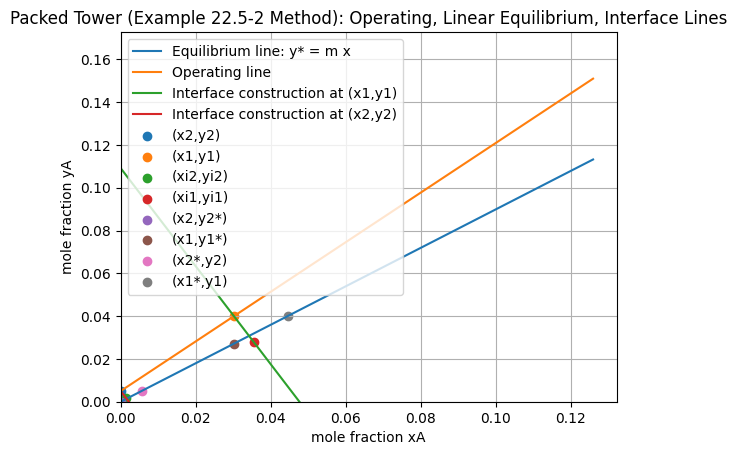

In [ ]:
# notebook cell: 22.5-6.py

import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from bank.Absorption.packed_absorption_height_base import (
    PackedTowerExample2252Spec,
    packed_height_example2252_all,
)
from bank.Tower.equilibrium_linear_slope_base import (
    LinearSlopeFitSpec,
    linear_equilibrium_slope_from_table,
)

# ---------------------------
# Given (NH3 case)
# ---------------------------
y1 = 0.040             # bulk gas at rich end
y2 = 0.005             # bulk gas at lean end
L_prime = 68.0         # kgmol/h
D = 0.747              # m
x2 = 0.0               # pure water in

# Use V' directly (given explicitly)
V_prime = 57.8         # kgmol/h

# Volumetric film coefficients given per second -> convert to per hour to match kgmol/h flows
kya_s = 0.0739
kxa_s = 0.169
kya = kya_s * 3600.0
kxa = kxa_s * 3600.0

# -------------------------------------------------
# 293 K (20°C) equilibrium table: y at P=1 atm vs x
# (full table so the slope can be determined from it)
# -------------------------------------------------
xA_table_293K = np.array([
    0.0, 0.0126, 0.0167, 0.0208, 0.0258, 0.0309, 0.0405, 0.0503, 0.0737, 0.0960,
    0.137, 0.175, 0.210, 0.241, 0.297
], dtype=float)

yA_table_293K = np.array([
    0.0, 0.0151, 0.0201, 0.0158, 0.0197, 0.0239, 0.0328, 0.0416, 0.0657, 0.0915,
    0.150, 0.218, 0.298, 0.392, 0.618
], dtype=float)

# ---------------------------
# Determine linear-equilibrium slope m for y* = m x
# Pick one method:
#   - fit_origin over dilute region (recommended for y*=mx)
#   - point using x_ref=0.0405
# ---------------------------
slope_pack = linear_equilibrium_slope_from_table(
    LinearSlopeFitSpec(
        x=xA_table_293K,
        y=yA_table_293K,
        method="fit_origin",
        x_max=0.10,          # dilute region selection (edit if needed)
        # method="point", x_ref=0.0405
    )
)
m = slope_pack["m"]
print("Equilibrium slope m for y* = m x =", m)
print("Slope method detail:", slope_pack)

# ---------------------------
# For interface calculations in the Example 22.5-2 method, the bank uses a table.
# Provide the same table to the bank solver.
# ---------------------------
spec = PackedTowerExample2252Spec(
    V_prime=V_prime,
    L_prime=L_prime,
    y1=y1,
    y2=y2,
    x2=x2,
    diameter_m=D,
    x_eq=xA_table_293K.tolist(),
    y_eq=yA_table_293K.tolist(),
    k_ya=kya,
    k_xa=kxa,
    n_scan=12001,
    it_max=80,
    tol_slope=1e-10,
)

res = packed_height_example2252_all(spec)

# ---------------------------
# Extract results
# ---------------------------
x1 = res["bulk"]["x1"]

xi1 = res["interface"]["top"]["x_i1"]
yi1 = res["interface"]["top"]["y_i1"]
slope1 = res["interface"]["top"]["slope"]

xi2 = res["interface"]["bottom"]["x_i2"]
yi2 = res["interface"]["bottom"]["y_i2"]
slope2 = res["interface"]["bottom"]["slope"]

S = res["averages"]["S_m2"]
V1 = res["averages"]["V1"]
V2 = res["averages"]["V2"]
Vav = res["averages"]["Vav"]
Lav = res["averages"]["Lav"]  # equals L' in the example approximation

# ---------------------------
# Star values for verification using LINEAR equilibrium y* = m x
# ---------------------------
y1_star = m * x1
y2_star = m * x2

x1_star = y1 / m
x2_star = y2 / m

# Operating line slope in x-y
op_slope = (y1 - y2) / (x1 - x2) if abs(x1 - x2) > 0 else float("nan")

# Liquid total flows at ends (verification)
L1_total = L_prime / (1.0 - x1)
L2_total = L_prime / (1.0 - x2)
Lav_total = 0.5 * (L1_total + L2_total)

# ---------------------------
# Print verification values
# ---------------------------
print("\n=== Heights (m) ===")
print("z using k'ya =", res["heights"]["z_using_kya"])
print("z using k'xa =", res["heights"]["z_using_kxa"])
print("z using K'ya =", res["heights"]["z_using_Kya"])

print("\n=== Slopes ===")
print("Operating line slope dy/dx =", op_slope)
print("Interface construction slope at (x1,y1) =", slope1)
print("Interface construction slope at (x2,y2) =", slope2)

print("\n=== Gas flows ===")
print("V' =", V_prime)
print("V1 = V'/(1-y1) =", V1)
print("V2 = V'/(1-y2) =", V2)
print("Vav =", Vav)

print("\n=== Liquid flows ===")
print("L' (solute-free) =", L_prime)
print("L1(total) = L'/(1-x1) =", L1_total)
print("L2(total) = L'/(1-x2) =", L2_total)
print("Lav(total) =", Lav_total)
print("Lav (example uses ~ L') =", Lav)

print("\n=== Bulk / Interface / Star values ===")
print("Bulk:      x2 =", x2, " y2 =", y2)
print("Bulk:      x1 =", x1, " y1 =", y1)

print("Interface: xi2 =", xi2, " yi2 =", yi2)
print("Interface: xi1 =", xi1, " yi1 =", yi1)

print("Star (eq): y2* =", y2_star, " at x2")
print("Star (eq): y1* =", y1_star, " at x1")

print("Star (eq): x2* =", x2_star, " at y2")
print("Star (eq): x1* =", x1_star, " at y1")

# ---------------------------
# Plot: Equilibrium (STRAIGHT y*=mx), Operating, Interface construction lines, points
# ---------------------------
x_max_plot = max(0.12, x1, xi1, xi2, x1_star) * 1.05
x_grid = np.linspace(0.0, x_max_plot, 900)

# Linear equilibrium line (no interpolation artifacts)
y_eq_lin = m * x_grid

# Operating line through (x2,y2) and (x1,y1)
y_op = y2 + (y1 - y2) * (x_grid - x2) / (x1 - x2) if abs(x1 - x2) > 0 else np.full_like(x_grid, np.nan)

# Interface construction lines
y_line_top = y1 + slope1 * (x_grid - x1)
y_line_bot = y2 + slope2 * (x_grid - x2)

plt.figure()
plt.plot(x_grid, y_eq_lin, label="Equilibrium line: y* = m x")
plt.plot(x_grid, y_op, label="Operating line")
plt.plot(x_grid, y_line_top, label="Interface construction at (x1,y1)")
plt.plot(x_grid, y_line_bot, label="Interface construction at (x2,y2)")

# Points
plt.scatter([x2], [y2], label="(x2,y2)", marker="o")
plt.scatter([x1], [y1], label="(x1,y1)", marker="o")
plt.scatter([xi2], [yi2], label="(xi2,yi2)", marker="o")
plt.scatter([xi1], [yi1], label="(xi1,yi1)", marker="o")

# Star points (linear equilibrium)
plt.scatter([x2], [y2_star], label="(x2,y2*)", marker="o")
plt.scatter([x1], [y1_star], label="(x1,y1*)", marker="o")
plt.scatter([x2_star], [y2], label="(x2*,y2)", marker="o")
plt.scatter([x1_star], [y1], label="(x1*,y1)", marker="o")

plt.xlabel("mole fraction xA")
plt.ylabel("mole fraction yA")
plt.title("Packed Tower (Example 22.5-2 Method): Operating, Linear Equilibrium, Interface Lines")
plt.xlim(left=0.0)
plt.ylim(bottom=0.0)
plt.grid(True)
plt.legend()
plt.show()